# Data Science 2 Seminar paper
## Business/project evaluation stage

### Premise
What is the effect of personal travel on CoViD-19 infection rates in the tri-state area?
As some of the possible factors I will look into:
- open vs closed borders  
- open vs closed stores 
- vacation times

Since border traffic was never entirely shut down for business traffic i.e. commuters we won't look into that. 

The hypothesis is that all 3 factores have an impact on infection rates. If that can be shown, I will try to form a prediction model for future holidays.

### Preliminary plan of action
* Define area of relevance based on travel/shopping/commute
* Evaluate infection response/delay windows to apply to infection timelines
* Construct an infection spike timeline for border region. 
  * Combined and statebased.
  * Classify days as rising infection/not
* Construct independent/combined timelines for borders' state, stores' state and vacation times. 
* Test correlation to CoViD-19 statistics in the involved countries/overall
* Classify spike events as border/store/vacation
* See if a prediction can be made



### Data evaluation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from utility.helpers import *
import utility.init as util

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slowe

## Importing data

In [2]:
emr_df = pd.read_csv(util.emr_infection_data)
de_ref_df = pd.read_csv(util.de_reference_data)

# add date typ columns
emr_df = addDateTypeColumn(emr_df,'XDate')
de_ref_df = addDateTypeColumn(de_ref_df,'XDate')

# Sketch

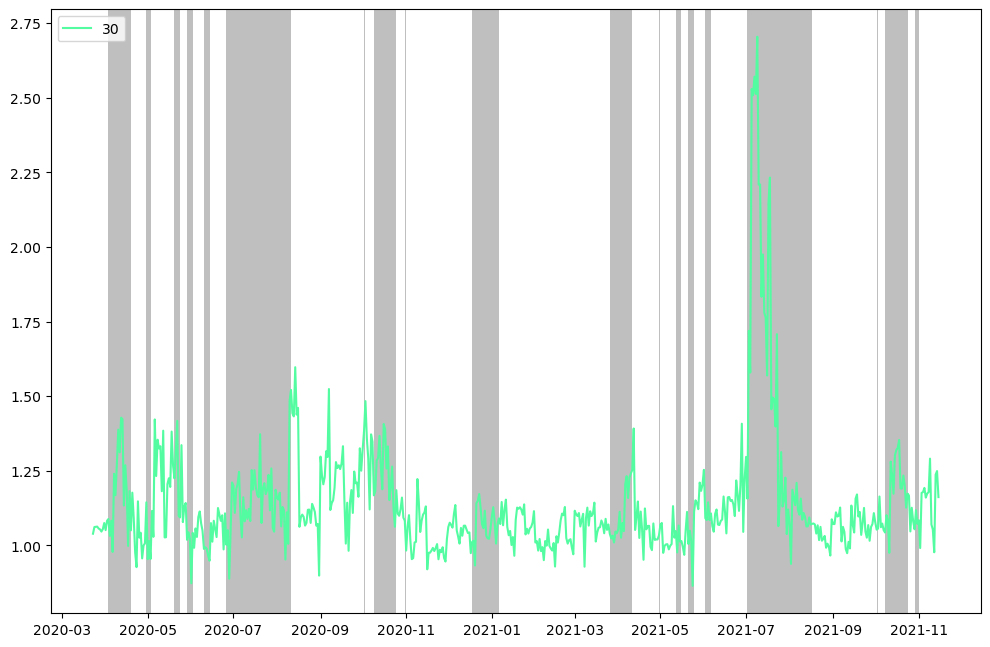

In [3]:
for clazz, color in util.class_colors.items():
    if clazz in [30]:
        x = emr_df.loc[emr_df['Province_Id']== clazz, 'XDate']
        y = emr_df.loc[emr_df['Province_Id']== clazz, 'N_Day_Rate_Change_Sliding_Window']
        plt.plot(x,y, label = clazz, color = color)

addDayOffStreaks(de_ref_df)

plt.legend()
plt.show()